In [1]:
# load densenet arch and make an eye detector (idea: with attention regions)

In [1]:
import os
import sys

sys.path.append('../')

import cv2
import json
import math
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import load_image
from augmentations import avg_aug

In [2]:
from tflow.DenseNet10.keras_fc_densenet import _create_fc_dense_net
from tflow.DenseNet10.keras_fc_densenet import _dense_block, _transition_down_block

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Input, BatchNormalization, Activation, Dropout, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [4]:
# make a better way to store all this in a config.json file to be readable as "experiment" counter # save a list of this json objects

img_input = Input((224, 224, 3))
bn_momentum = 0.9
concat_axis = -1
data_format = "channels_last"
dropout_rate = 0.2
weight_decay = 1e-4
transition_pooling = 'max'

# Initial convolution
with tf.name_scope("Initial"):
    x = Conv2D(
        36,
        (3, 3),
        kernel_initializer="he_normal",
        padding="same",
        use_bias=False,
        kernel_regularizer=l2(weight_decay),
        data_format=data_format,
    )(img_input)
    x = BatchNormalization(
        momentum=bn_momentum, axis=concat_axis, epsilon=1.1e-5
    )(x)
    x = Activation("relu")(x)

2022-08-04 12:05:37.786502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 12:05:38.086598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 12:05:38.088382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 12:05:38.091045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [5]:
# keeps track of the current number of feature maps
nb_filter = 42
growth_rate = 3
nb_dense_block = 5
nb_layers_per_block = 3
bottleneck_nb_layers = nb_layers_per_block
nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

# collect skip connections on the downsampling path so that
# they can be concatenated with outputs on the upsampling path
# skip_list = []

# Build the downsampling path by adding dense blocks and transition down blocks
for block_idx in range(nb_dense_block):
    x, nb_filter, _ = _dense_block(
        x,
        nb_layers[block_idx],
        nb_filter,
        growth_rate,
        bn_momentum=bn_momentum,
        dropout_rate=dropout_rate,
        data_format=data_format,
        block_prefix="DenseBlock_%i" % block_idx,
    )

    # skip_list.append(x)
    x = _transition_down_block(
        x,
        nb_filter,
        weight_decay=weight_decay,
        bn_momentum=bn_momentum,
        transition_pooling=transition_pooling,
        data_format=data_format,
        block_prefix="TransitionDown_%i" % block_idx,
    )

x, nb_filter, _ = _dense_block(
    x,
    nb_layers[-1],
    nb_filter,
    growth_rate,
    bn_momentum=bn_momentum,
    dropout_rate=dropout_rate,
    data_format=data_format,
    block_prefix="DenseBlock_last",
)

x = GlobalMaxPool2D()(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Dropout(rate=dropout_rate)(x)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Dropout(rate=dropout_rate)(x)

x = Dense(4, activation='sigmoid')(x)

In [6]:
model = Model(inputs=img_input, outputs=x)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 36  972         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 36  144        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Generator funct

In [8]:
# TODO: implement data augmentation for object detection

datapath = {
    'images_path': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked",
    'via_file': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked/via_region_data.json"
}

In [9]:
with open(datapath.get('via_file')) as f:
    data = json.load(f)
    images_tensor = []
    coords_tensor = []
    
    for key in data.keys():
        impath = os.path.join(datapath.get('images_path'), data[key].get('filename'))
        # need to get image shape to properly format regions
        # image = Image.open(impath)
        # im_width, im_height = image.size
                     
        regions = data[key]['regions']
        
        if regions: # will be a empty list or list of regions
            shape_attributes = regions[0]['shape_attributes'] # take the first because is the unique region on the image
            # load marks
            region_name = shape_attributes.get('name') # will return "rect". Not used
            x = shape_attributes.get('x')
            y = shape_attributes.get('y')
            width = shape_attributes.get('width')
            height = shape_attributes.get('height')
            
            # make array with batch size and coords
            # coords = np.array([x, y, x+width, y+height])
            coords = np.array([x, y, width, height])
            
            # append data to tensors
            images_tensor.append(impath)
            coords_tensor.append(coords)

aug = avg_aug()
# define train/test/val here spliting those tensor
images_tensor = tf.cast(images_tensor, dtype=tf.string)
coords_tensor = tf.cast(coords_tensor, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((images_tensor, coords_tensor))

def _parse_function(impath, coords):
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    h_image = tf.shape(image_decoded)[0]
    w_image = tf.shape(image_decoded)[1]
    image = tf.image.resize(image_decoded, (224, 224))
    image = tf.cast(image, tf.uint8)
    # do augmentation here. Had a lot of problems figuring how to solve this part xd
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    coords = coords / [w_image, h_image, w_image, h_image] # image width, height
    return image, coords

dataset = dataset.map(_parse_function)
dataset = dataset.cache()
dataset = dataset.batch(5)
dataset = dataset.shuffle(5**2)

In [10]:
dataset, len(dataset)

(<ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>,
 230)

In [11]:
train_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
val_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

# Show first image from train set

In [12]:
# for im, coords in dataset.take(1):
#     plt.imshow(im[0])
#     plt.show()
#     print(coords[0])

# Train config

In [13]:
# another ref with more iou metrics: https://chowdera.com/2022/04/202204081842317781.html

# ref: https://github.com/Balupurohit23/IOU-for-bounding-box-regression-in-Keras/blob/master/iou_metric.py
def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = tf.abs(tf.transpose(y_true)[2] - tf.transpose(y_true)[0] + 1) * tf.abs(tf.transpose(y_true)[3] - tf.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = tf.abs(tf.transpose(y_pred)[2] - tf.transpose(y_pred)[0] + 1) * tf.abs(tf.transpose(y_pred)[3] - tf.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = tf.maximum(tf.transpose(y_true)[0], tf.transpose(y_pred)[0])
    overlap_1 = tf.maximum(tf.transpose(y_true)[1], tf.transpose(y_pred)[1])
    overlap_2 = tf.minimum(tf.transpose(y_true)[2], tf.transpose(y_pred)[2])
    overlap_3 = tf.minimum(tf.transpose(y_true)[3], tf.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = tf.clip_by_value(iou, 0.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

    return iou   

In [14]:
lr = 1e-4

# converge muy rapido
opt = tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    name='RMSpropOpt',
)

# delicioso
# opt = tf.keras.optimizers.SGD(
#     learning_rate=lr,
#     momentum=0.9,
#     nesterov=True,
#     name='SGDOpt',
# )

model.compile(
    optimizer=opt,
    loss=tf.losses.MeanSquaredError(),
    # loss=tf.losses.MeanSquaredLogarithmicError(),
    # loss=iou_loss,
    metrics=[
        'mae', 'mse', 
        iou_metric
    ]
)

# Callbacks

In [15]:
callbacks = [ # add save save best model
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-15,
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=20,
    )
]

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    max_queue_size=32,
    workers=10,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/150


/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thes

  4/230 [..............................] - ETA: 23s - loss: 0.2145 - mae: 0.3193 - mse: 0.1375 - iou_metric: 0.3064  

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


  5/230 [..............................] - ETA: 50s - loss: 0.2119 - mae: 0.3186 - mse: 0.1349 - iou_metric: 0.2988

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


  7/230 [..............................] - ETA: 49s - loss: 0.2076 - mae: 0.3106 - mse: 0.1306 - iou_metric: 0.3089

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


  8/230 [>.............................] - ETA: 55s - loss: 0.2043 - mae: 0.3027 - mse: 0.1273 - iou_metric: 0.3221

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


  9/230 [>.............................] - ETA: 55s - loss: 0.1976 - mae: 0.2920 - mse: 0.1206 - iou_metric: 0.3378

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 11/230 [>.............................] - ETA: 1:02 - loss: 0.1941 - mae: 0.2835 - mse: 0.1171 - iou_metric: 0.3491

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 12/230 [>.............................] - ETA: 59s - loss: 0.1914 - mae: 0.2793 - mse: 0.1145 - iou_metric: 0.3535 

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 13/230 [>.............................] - ETA: 1:05 - loss: 0.1885 - mae: 0.2751 - mse: 0.1115 - iou_metric: 0.3610

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 15/230 [>.............................] - ETA: 59s - loss: 0.1833 - mae: 0.2664 - mse: 0.1063 - iou_metric: 0.3740 

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 17/230 [=>............................] - ETA: 55s - loss: 0.1776 - mae: 0.2584 - mse: 0.1006 - iou_metric: 0.3819

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 19/230 [=>............................] - ETA: 52s - loss: 0.1754 - mae: 0.2534 - mse: 0.0984 - iou_metric: 0.3901

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 20/230 [=>............................] - ETA: 54s - loss: 0.1733 - mae: 0.2506 - mse: 0.0963 - iou_metric: 0.3929

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 22/230 [=>............................] - ETA: 52s - loss: 0.1710 - mae: 0.2471 - mse: 0.0940 - iou_metric: 0.3967

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 23/230 [==>...........................] - ETA: 53s - loss: 0.1686 - mae: 0.2421 - mse: 0.0916 - iou_metric: 0.4056

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 25/230 [==>...........................] - ETA: 51s - loss: 0.1657 - mae: 0.2366 - mse: 0.0887 - iou_metric: 0.4167

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 29/230 [==>...........................] - ETA: 49s - loss: 0.1589 - mae: 0.2253 - mse: 0.0820 - iou_metric: 0.4368

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 30/230 [==>...........................] - ETA: 51s - loss: 0.1571 - mae: 0.2225 - mse: 0.0801 - iou_metric: 0.4426

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 32/230 [===>..........................] - ETA: 50s - loss: 0.1547 - mae: 0.2189 - mse: 0.0777 - iou_metric: 0.4486

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 33/230 [===>..........................] - ETA: 50s - loss: 0.1538 - mae: 0.2173 - mse: 0.0768 - iou_metric: 0.4522

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 35/230 [===>..........................] - ETA: 48s - loss: 0.1523 - mae: 0.2147 - mse: 0.0753 - iou_metric: 0.4585

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 39/230 [====>.........................] - ETA: 44s - loss: 0.1489 - mae: 0.2086 - mse: 0.0719 - iou_metric: 0.4702

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 40/230 [====>.........................] - ETA: 45s - loss: 0.1478 - mae: 0.2067 - mse: 0.0709 - iou_metric: 0.4737

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 45/230 [====>.........................] - ETA: 41s - loss: 0.1432 - mae: 0.1983 - mse: 0.0662 - iou_metric: 0.4907

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 46/230 [=====>........................] - ETA: 40s - loss: 0.1429 - mae: 0.1981 - mse: 0.0659 - iou_metric: 0.4915

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 48/230 [=====>........................] - ETA: 40s - loss: 0.1417 - mae: 0.1960 - mse: 0.0647 - iou_metric: 0.4958

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 50/230 [=====>........................] - ETA: 39s - loss: 0.1407 - mae: 0.1946 - mse: 0.0637 - iou_metric: 0.4980

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 53/230 [=====>........................] - ETA: 37s - loss: 0.1392 - mae: 0.1917 - mse: 0.0623 - iou_metric: 0.5044

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 54/230 [======>.......................] - ETA: 37s - loss: 0.1389 - mae: 0.1911 - mse: 0.0619 - iou_metric: 0.5057

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 55/230 [======>.......................] - ETA: 39s - loss: 0.1383 - mae: 0.1905 - mse: 0.0614 - iou_metric: 0.5066

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 56/230 [======>.......................] - ETA: 38s - loss: 0.1380 - mae: 0.1900 - mse: 0.0611 - iou_metric: 0.5078

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 57/230 [======>.......................] - ETA: 38s - loss: 0.1377 - mae: 0.1897 - mse: 0.0608 - iou_metric: 0.5080

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 60/230 [======>.......................] - ETA: 37s - loss: 0.1363 - mae: 0.1872 - mse: 0.0594 - iou_metric: 0.5126

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 61/230 [======>.......................] - ETA: 37s - loss: 0.1357 - mae: 0.1864 - mse: 0.0588 - iou_metric: 0.5137

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 62/230 [=======>......................] - ETA: 37s - loss: 0.1350 - mae: 0.1848 - mse: 0.0580 - iou_metric: 0.5169

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thes

 63/230 [=======>......................] - ETA: 39s - loss: 0.1344 - mae: 0.1840 - mse: 0.0575 - iou_metric: 0.5187

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-20

 64/230 [=======>......................] - ETA: 40s - loss: 0.1340 - mae: 0.1835 - mse: 0.0571 - iou_metric: 0.5196

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 66/230 [=======>......................] - ETA: 39s - loss: 0.1332 - mae: 0.1821 - mse: 0.0562 - iou_metric: 0.5222

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 70/230 [========>.....................] - ETA: 37s - loss: 0.1317 - mae: 0.1796 - mse: 0.0548 - iou_metric: 0.5273

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 72/230 [========>.....................] - ETA: 36s - loss: 0.1307 - mae: 0.1772 - mse: 0.0538 - iou_metric: 0.5326

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 73/230 [========>.....................] - ETA: 37s - loss: 0.1306 - mae: 0.1768 - mse: 0.0536 - iou_metric: 0.5334

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib

 76/230 [========>.....................] - ETA: 36s - loss: 0.1297 - mae: 0.1754 - mse: 0.0528 - iou_metric: 0.5358

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thes

 77/230 [=========>....................] - ETA: 36s - loss: 0.1292 - mae: 0.1745 - mse: 0.0523 - iou_metric: 0.5374

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 80/230 [=========>....................] - ETA: 35s - loss: 0.1282 - mae: 0.1726 - mse: 0.0512 - iou_metric: 0.5408

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 82/230 [=========>....................] - ETA: 34s - loss: 0.1275 - mae: 0.1715 - mse: 0.0506 - iou_metric: 0.5424

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 83/230 [=========>....................] - ETA: 34s - loss: 0.1271 - mae: 0.1708 - mse: 0.0502 - iou_metric: 0.5439

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 84/230 [=========>....................] - ETA: 34s - loss: 0.1269 - mae: 0.1703 - mse: 0.0500 - iou_metric: 0.5452

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 85/230 [==========>...................] - ETA: 34s - loss: 0.1265 - mae: 0.1694 - mse: 0.0496 - iou_metric: 0.5468

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 86/230 [==========>...................] - ETA: 35s - loss: 0.1261 - mae: 0.1688 - mse: 0.0492 - iou_metric: 0.5479

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 88/230 [==========>...................] - ETA: 34s - loss: 0.1256 - mae: 0.1677 - mse: 0.0487 - iou_metric: 0.5500

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 89/230 [==========>...................] - ETA: 34s - loss: 0.1253 - mae: 0.1670 - mse: 0.0484 - iou_metric: 0.5514

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 90/230 [==========>...................] - ETA: 34s - loss: 0.1249 - mae: 0.1663 - mse: 0.0480 - iou_metric: 0.5526

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 94/230 [===========>..................] - ETA: 32s - loss: 0.1237 - mae: 0.1640 - mse: 0.0468 - iou_metric: 0.5573

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 97/230 [===========>..................] - ETA: 32s - loss: 0.1231 - mae: 0.1632 - mse: 0.0463 - iou_metric: 0.5588

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


 98/230 [===========>..................] - ETA: 31s - loss: 0.1228 - mae: 0.1625 - mse: 0.0459 - iou_metric: 0.5603

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


100/230 [============>.................] - ETA: 31s - loss: 0.1224 - mae: 0.1618 - mse: 0.0455 - iou_metric: 0.5616

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


102/230 [============>.................] - ETA: 30s - loss: 0.1219 - mae: 0.1609 - mse: 0.0450 - iou_metric: 0.5634

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


104/230 [============>.................] - ETA: 29s - loss: 0.1214 - mae: 0.1599 - mse: 0.0445 - iou_metric: 0.5654

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


106/230 [============>.................] - ETA: 29s - loss: 0.1210 - mae: 0.1593 - mse: 0.0442 - iou_metric: 0.5666

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


108/230 [=============>................] - ETA: 28s - loss: 0.1205 - mae: 0.1582 - mse: 0.0437 - iou_metric: 0.5691

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


111/230 [=============>................] - ETA: 27s - loss: 0.1199 - mae: 0.1570 - mse: 0.0430 - iou_metric: 0.5713

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


113/230 [=============>................] - ETA: 27s - loss: 0.1195 - mae: 0.1565 - mse: 0.0427 - iou_metric: 0.5721

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib

115/230 [==============>...............] - ETA: 27s - loss: 0.1190 - mae: 0.1556 - mse: 0.0422 - iou_metric: 0.5738

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


117/230 [==============>...............] - ETA: 26s - loss: 0.1188 - mae: 0.1551 - mse: 0.0420 - iou_metric: 0.5748

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


118/230 [==============>...............] - ETA: 26s - loss: 0.1186 - mae: 0.1548 - mse: 0.0418 - iou_metric: 0.5751

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-20

119/230 [==============>...............] - ETA: 26s - loss: 0.1183 - mae: 0.1542 - mse: 0.0415 - iou_metric: 0.5764

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


122/230 [==============>...............] - ETA: 25s - loss: 0.1178 - mae: 0.1532 - mse: 0.0410 - iou_metric: 0.5788

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


125/230 [===============>..............] - ETA: 25s - loss: 0.1174 - mae: 0.1527 - mse: 0.0406 - iou_metric: 0.5798

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


127/230 [===============>..............] - ETA: 24s - loss: 0.1171 - mae: 0.1519 - mse: 0.0403 - iou_metric: 0.5814

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


128/230 [===============>..............] - ETA: 24s - loss: 0.1170 - mae: 0.1518 - mse: 0.0402 - iou_metric: 0.5818

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


129/230 [===============>..............] - ETA: 24s - loss: 0.1168 - mae: 0.1514 - mse: 0.0400 - iou_metric: 0.5825

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


131/230 [================>.............] - ETA: 24s - loss: 0.1167 - mae: 0.1512 - mse: 0.0399 - iou_metric: 0.5830

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


132/230 [================>.............] - ETA: 23s - loss: 0.1165 - mae: 0.1508 - mse: 0.0397 - iou_metric: 0.5837

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/en

135/230 [================>.............] - ETA: 23s - loss: 0.1162 - mae: 0.1504 - mse: 0.0394 - iou_metric: 0.5846

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


136/230 [================>.............] - ETA: 23s - loss: 0.1161 - mae: 0.1502 - mse: 0.0393 - iou_metric: 0.5849

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


138/230 [=================>............] - ETA: 22s - loss: 0.1157 - mae: 0.1496 - mse: 0.0390 - iou_metric: 0.5863

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


141/230 [=================>............] - ETA: 21s - loss: 0.1154 - mae: 0.1488 - mse: 0.0387 - iou_metric: 0.5882

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


143/230 [=================>............] - ETA: 21s - loss: 0.1154 - mae: 0.1487 - mse: 0.0386 - iou_metric: 0.5885

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


145/230 [=================>............] - ETA: 20s - loss: 0.1153 - mae: 0.1487 - mse: 0.0386 - iou_metric: 0.5887

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thes

146/230 [==================>...........] - ETA: 20s - loss: 0.1151 - mae: 0.1481 - mse: 0.0384 - iou_metric: 0.5900

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


147/230 [==================>...........] - ETA: 20s - loss: 0.1151 - mae: 0.1482 - mse: 0.0384 - iou_metric: 0.5898

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


149/230 [==================>...........] - ETA: 20s - loss: 0.1149 - mae: 0.1478 - mse: 0.0382 - iou_metric: 0.5904

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


150/230 [==================>...........] - ETA: 20s - loss: 0.1149 - mae: 0.1479 - mse: 0.0382 - iou_metric: 0.5903

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


151/230 [==================>...........] - ETA: 19s - loss: 0.1147 - mae: 0.1476 - mse: 0.0380 - iou_metric: 0.5911

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


153/230 [==================>...........] - ETA: 19s - loss: 0.1145 - mae: 0.1472 - mse: 0.0378 - iou_metric: 0.5918

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


154/230 [===================>..........] - ETA: 19s - loss: 0.1145 - mae: 0.1471 - mse: 0.0378 - iou_metric: 0.5921

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib

157/230 [===================>..........] - ETA: 18s - loss: 0.1140 - mae: 0.1463 - mse: 0.0373 - iou_metric: 0.5936

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


158/230 [===================>..........] - ETA: 18s - loss: 0.1139 - mae: 0.1461 - mse: 0.0372 - iou_metric: 0.5941

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/en

159/230 [===================>..........] - ETA: 17s - loss: 0.1138 - mae: 0.1459 - mse: 0.0371 - iou_metric: 0.5943

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


160/230 [===================>..........] - ETA: 17s - loss: 0.1137 - mae: 0.1456 - mse: 0.0370 - iou_metric: 0.5950

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


163/230 [====================>.........] - ETA: 16s - loss: 0.1133 - mae: 0.1450 - mse: 0.0367 - iou_metric: 0.5961

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


164/230 [====================>.........] - ETA: 16s - loss: 0.1133 - mae: 0.1450 - mse: 0.0366 - iou_metric: 0.5961

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc

167/230 [====================>.........] - ETA: 15s - loss: 0.1129 - mae: 0.1442 - mse: 0.0363 - iou_metric: 0.5980

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


169/230 [=====================>........] - ETA: 15s - loss: 0.1128 - mae: 0.1442 - mse: 0.0362 - iou_metric: 0.5981

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


172/230 [=====================>........] - ETA: 14s - loss: 0.1125 - mae: 0.1434 - mse: 0.0358 - iou_metric: 0.5997

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


173/230 [=====================>........] - ETA: 14s - loss: 0.1124 - mae: 0.1432 - mse: 0.0357 - iou_metric: 0.6003

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


174/230 [=====================>........] - ETA: 14s - loss: 0.1123 - mae: 0.1430 - mse: 0.0356 - iou_metric: 0.6007

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


176/230 [=====================>........] - ETA: 13s - loss: 0.1120 - mae: 0.1425 - mse: 0.0354 - iou_metric: 0.6015

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


177/230 [======================>.......] - ETA: 13s - loss: 0.1119 - mae: 0.1423 - mse: 0.0353 - iou_metric: 0.6021

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


179/230 [======================>.......] - ETA: 12s - loss: 0.1118 - mae: 0.1422 - mse: 0.0352 - iou_metric: 0.6023

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


181/230 [======================>.......] - ETA: 12s - loss: 0.1117 - mae: 0.1420 - mse: 0.0351 - iou_metric: 0.6027

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


182/230 [======================>.......] - ETA: 12s - loss: 0.1116 - mae: 0.1419 - mse: 0.0350 - iou_metric: 0.6030

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


183/230 [======================>.......] - ETA: 11s - loss: 0.1115 - mae: 0.1415 - mse: 0.0349 - iou_metric: 0.6039

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


185/230 [=======================>......] - ETA: 11s - loss: 0.1113 - mae: 0.1411 - mse: 0.0347 - iou_metric: 0.6049

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


186/230 [=======================>......] - ETA: 11s - loss: 0.1112 - mae: 0.1407 - mse: 0.0346 - iou_metric: 0.6057

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


189/230 [=======================>......] - ETA: 10s - loss: 0.1110 - mae: 0.1404 - mse: 0.0344 - iou_metric: 0.6060

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


191/230 [=======================>......] - ETA: 9s - loss: 0.1108 - mae: 0.1400 - mse: 0.0342 - iou_metric: 0.6070 

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


192/230 [========================>.....] - ETA: 9s - loss: 0.1107 - mae: 0.1398 - mse: 0.0341 - iou_metric: 0.6072

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


193/230 [========================>.....] - ETA: 9s - loss: 0.1106 - mae: 0.1395 - mse: 0.0340 - iou_metric: 0.6079

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-20

194/230 [========================>.....] - ETA: 9s - loss: 0.1105 - mae: 0.1394 - mse: 0.0340 - iou_metric: 0.6080

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


196/230 [========================>.....] - ETA: 8s - loss: 0.1103 - mae: 0.1391 - mse: 0.0338 - iou_metric: 0.6087

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


197/230 [========================>.....] - ETA: 8s - loss: 0.1103 - mae: 0.1391 - mse: 0.0338 - iou_metric: 0.6085

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


198/230 [========================>.....] - ETA: 8s - loss: 0.1103 - mae: 0.1391 - mse: 0.0338 - iou_metric: 0.6086

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


200/230 [=========================>....] - ETA: 7s - loss: 0.1101 - mae: 0.1388 - mse: 0.0336 - iou_metric: 0.6092

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


201/230 [=========================>....] - ETA: 7s - loss: 0.1101 - mae: 0.1388 - mse: 0.0336 - iou_metric: 0.6090

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


202/230 [=========================>....] - ETA: 7s - loss: 0.1100 - mae: 0.1387 - mse: 0.0335 - iou_metric: 0.6091

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


203/230 [=========================>....] - ETA: 7s - loss: 0.1100 - mae: 0.1387 - mse: 0.0335 - iou_metric: 0.6092

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


207/230 [==========================>...] - ETA: 5s - loss: 0.1097 - mae: 0.1381 - mse: 0.0332 - iou_metric: 0.6103

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


230/230 [==============================] - 81s 270ms/step - loss: 0.1081 - mae: 0.1351 - mse: 0.0318 - iou_metric: 0.6168 - val_loss: 0.0888 - val_mae: 0.0873 - val_mse: 0.0136 - val_iou_metric: 0.7342 - lr: 1.0000e-04
Epoch 2/150
230/230 [==============================] - 17s 73ms/step - loss: 0.0874 - mae: 0.0925 - mse: 0.0146 - iou_metric: 0.7144 - val_loss: 0.0794 - val_mae: 0.0691 - val_mse: 0.0093 - val_iou_metric: 0.7828 - lr: 1.0000e-04
Epoch 3/150
230/230 [==============================] - 17s 74ms/step - loss: 0.0785 - mae: 0.0823 - mse: 0.0119 - iou_metric: 0.7429 - val_loss: 0.0721 - val_mae: 0.0681 - val_mse: 0.0093 - val_iou_metric: 0.7862 - lr: 1.0000e-04
Epoch 4/150
230/230 [==============================] - 17s 75ms/step - loss: 0.0700 - mae: 0.0777 - mse: 0.0109 - iou_metric: 0.7556 - val_loss: 0.0644 - val_mae: 0.0670 - val_mse: 0.0091 - val_iou_metric: 0.7898 - lr: 1.0000e-04
Epoch 5/150
230/230 [==============================] - 17s 75ms/step - loss: 0.0619 - mae: 

In [17]:
# TODO: evaluate model with test data
# TODO: make ttv sets
# TODO: add bbox to perspective data augmentation

In [18]:
model.evaluate(val_ds)

230/230 [==============================] - 4s 17ms/step - loss: 0.0051 - mae: 0.0474 - mse: 0.0045 - iou_metric: 0.8397


[0.0050726886838674545,
 0.04738116264343262,
 0.004517003893852234,
 0.8396636843681335]

In [19]:
model.save(filepath='eye_detector_model.hdf5')

In [20]:
new_model = tf.keras.models.load_model(filepath='eye_detector_model.hdf5', custom_objects={'iou_metric': iou_metric})

In [21]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 36  972         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 36  144        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [22]:
# plot history with losses and metrics in two figures

In [23]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'iou_metric', 'val_loss', 'val_mae', 'val_mse', 'val_iou_metric', 'lr'])

In [24]:
lr = history.history.pop('lr', None) # not used

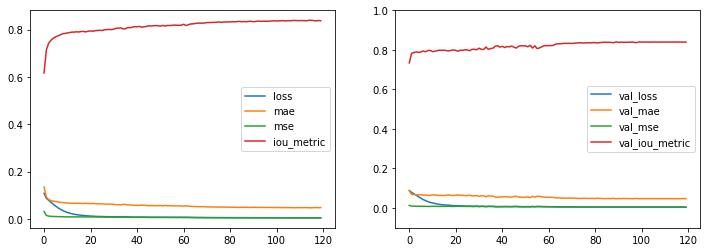

In [25]:
hist = history.history

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for key in hist.keys():
    if 'val_' not in key:
        axes[0].plot(hist[key], label=key)
    else:
        axes[1].plot(hist[key], label=key)

axes[0].legend()
axes[1].legend()

plt.ylim([-0.1, 1])
plt.show()